In [44]:

import ast
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

WIN_DIR = Path(r"E:\FILES\SCHOOL\MASTERS\DSE200\MINIPROJECT")
FALLBACK_DIR = Path("/mnt/data")
DATA_DIR = WIN_DIR if WIN_DIR.exists() else FALLBACK_DIR

portfolio_path = DATA_DIR / "portfolio.csv"
profile_path   = DATA_DIR / "profile.csv"
transcript_path= DATA_DIR / "transcript.xlsb"

portfolio_path, profile_path, transcript_path


(WindowsPath('E:/FILES/SCHOOL/MASTERS/DSE200/MINIPROJECT/portfolio.csv'),
 WindowsPath('E:/FILES/SCHOOL/MASTERS/DSE200/MINIPROJECT/profile.csv'),
 WindowsPath('E:/FILES/SCHOOL/MASTERS/DSE200/MINIPROJECT/transcript.xlsb'))

In [33]:


portfolio = pd.read_csv(portfolio_path)
profile   = pd.read_csv(profile_path)
try:
    transcript = pd.read_excel(transcript_path, engine="pyxlsb")
except Exception as e:
    print("mango")
    raise e

portfolio.head(2), profile.head(2), transcript.head(2)


(   Unnamed: 0  reward                              channels  difficulty  \
 0           0      10         ['email', 'mobile', 'social']          10   
 1           1      10  ['web', 'email', 'mobile', 'social']          10   
 
    duration offer_type                                id  
 0         7       bogo  ae264e3637204a6fb9bb56bc8210ddfd  
 1         5       bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  ,
    Unnamed: 0 gender  age                                id  became_member_on  \
 0           0    NaN  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
 1           1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
 
      income  
 0       NaN  
 1  112000.0  ,
    Unnamed: 0                            person           event  \
 0           0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
 1           1  a03223e636434f42ac4c3df47e8bac43  offer received   
 
                                               value  time  
 0  {'offer id': '9b98b8c7a3

In [34]:
def parse_channels(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return [c.strip() for c in x.strip("[]").split(",") if c.strip()]
    return []

portfolio = portfolio.rename(columns={"id":"offer_id"}).copy()
portfolio["channels_list"] = portfolio["channels"].apply(parse_channels)
portfolio["n_channels"] = portfolio["channels_list"].apply(len)
profile = profile.rename(columns={"id":"customer_id"}).copy()
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"], errors="coerce")
profile.loc[(profile["age"]<=0) | (profile["age"]>120), "age"] = np.nan
profile["age"] = profile["age"].fillna(profile["age"].median())
profile["income"] = profile["income"].fillna(profile["income"].median())
profile["gender"] = profile["gender"].fillna("U")
transcript = transcript.rename(columns={"person":"customer_id"}).copy()
transcript["event"] = transcript["event"].str.lower().str.strip()
transcript["time"] = pd.to_numeric(transcript["time"], errors="coerce").fillna(0).astype(int)

def unpack_value(v):
    if isinstance(v, dict):
        return pd.Series({"amount": v.get("amount"), "offer_id": v.get("offer id") or v.get("offer_id")})
    if isinstance(v, str):
        try:
            d = ast.literal_eval(v)
            if isinstance(d, dict):
                return pd.Series({"amount": d.get("amount"), "offer_id": d.get("offer id") or d.get("offer_id")})
        except:
            pass
    return pd.Series({"amount": None, "offer_id": None})

uv = transcript["value"].apply(unpack_value)
transcript = pd.concat([transcript.drop(columns=["value"]), uv], axis=1)

portfolio.head(1), profile.head(1), transcript.head(3)


(   Unnamed: 0  reward                       channels  difficulty  duration  \
 0           0      10  ['email', 'mobile', 'social']          10         7   
 
   offer_type                          offer_id            channels_list  \
 0       bogo  ae264e3637204a6fb9bb56bc8210ddfd  [email, mobile, social]   
 
    n_channels  
 0           3  ,
    Unnamed: 0 gender    age                       customer_id  \
 0           0      U  118.0  68be06ca386d4c31939f3a4f0e3dd783   
 
                became_member_on   income  
 0 1970-01-01 00:00:00.020170212  64000.0  ,
    Unnamed: 0                       customer_id           event  time  amount  \
 0           0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0     NaN   
 1           1  a03223e636434f42ac4c3df47e8bac43  offer received     0     NaN   
 2           2  e2127556f4f64592b11af22de27a7932  offer received     0     NaN   
 
                            offer_id  
 0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
 1  0b1e1539f2cc45b7

In [35]:
t = transcript.merge(
    portfolio[["offer_id","duration","difficulty","reward","offer_type","n_channels","channels_list"]],
    on="offer_id", how="left"
)
received = t[t["event"]=="offer received"][["customer_id","offer_id","time","duration","difficulty","reward","offer_type","n_channels"]].copy()
received = received.rename(columns={"time":"t_received"})
completed = t[t["event"]=="offer completed"][["customer_id","offer_id","time"]].copy()
completed = completed.rename(columns={"time":"t_completed"})
rc = received.merge(completed, on=["customer_id","offer_id"], how="left")
rc["within_window"] = (rc["t_completed"] - rc["t_received"] <= rc["duration"]*24) & ((rc["t_completed"] - rc["t_received"]) >= 0)
rc["offer_success"] = rc["within_window"].fillna(False).astype(int)
df = rc.merge(profile[["customer_id","gender","age","income","became_member_on"]], on="customer_id", how="left")
ref = pd.Timestamp("2018-12-31")
df["tenure_days"] = (ref - df["became_member_on"]).dt.days
df["tenure_days"] = df["tenure_days"].fillna(df["tenure_days"].median())

df.head(3)


,customer_id,offer_id,t_received,duration,difficulty,reward,offer_type,n_channels,t_completed,within_window,offer_success,gender,age,income,became_member_on,tenure_days
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,5.0,5.0,bogo,3.0,132.0,True,1,F,75.0,100000.0,1970-01-01 00:00:00.020170509,17895.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,20.0,5.0,discount,2.0,NaN,False,0,U,118.0,64000.0,1970-01-01 00:00:00.020170804,17895.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,10.0,2.0,discount,3.0,NaN,False,0,M,68.0,70000.0,1970-01-01 00:00:00.020180426,17895.0


offer_type
discount         0.529304
bogo             0.463575
informational    0.000000
Name: offer_success, dtype: float64


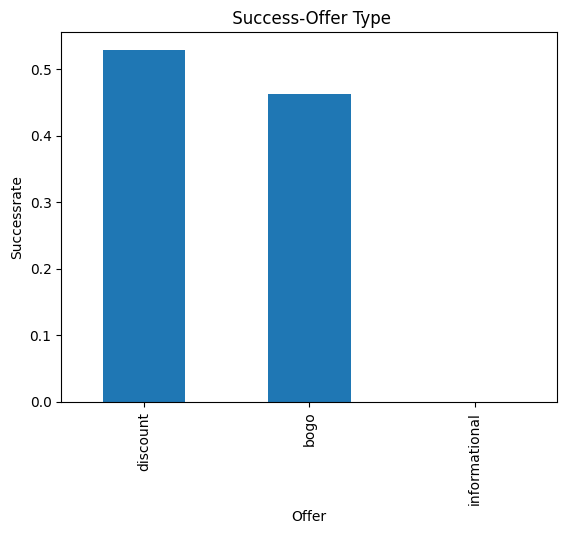

In [36]:
offer_type_sr = df.groupby("offer_type")["offer_success"].mean().sort_values(ascending=False)
print(offer_type_sr)
offer_type_sr.plot(kind="bar")
plt.title(" Success-Offer Type")
plt.ylabel("Successrate")
plt.xlabel("Offer")
plt.show()


duration_bucket
<=5      0.241252
6-7      0.502453
8-10     0.528383
11-14         NaN
15-30         NaN
>30           NaN
Name: offer_success, dtype: float64


C:\Users\carlo\AppData\Local\Temp\ipykernel_27768\2597342513.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_sr = df.groupby("duration_bucket")["offer_success"].mean().reindex(labels)


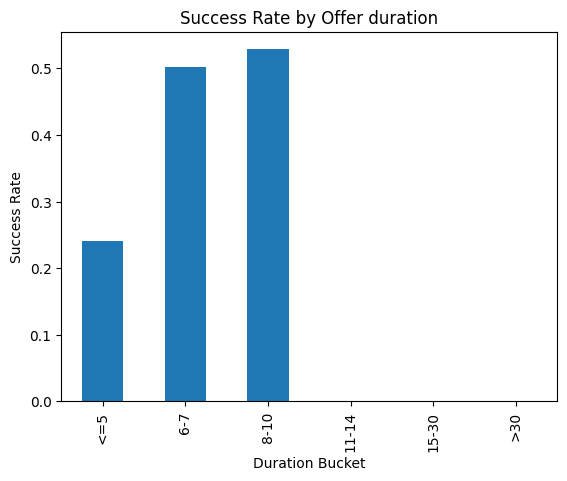

In [37]:

bins = [0,5,7,10,14,30,999]
labels = ["<=5","6-7","8-10","11-14","15-30",">30"]
df["duration_bucket"] = pd.cut(df["duration"], bins=bins, labels=labels, include_lowest=True, right=True)
duration_sr = df.groupby("duration_bucket")["offer_success"].mean().reindex(labels)
print(duration_sr)
duration_sr.plot(kind="bar")
plt.title("Success Rate by Offer duration")
plt.ylabel("Success Rate")
plt.xlabel("Duration Bucket")
plt.show()


n_channels
2.0    0.431120
3.0    0.302204
4.0    0.528562
Name: offer_success, dtype: float64


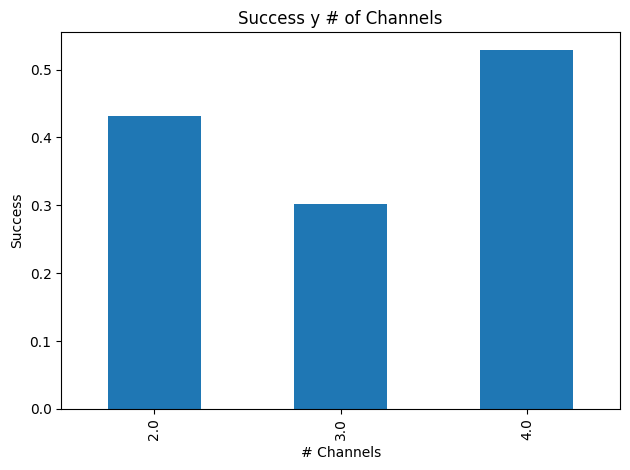

{'web': np.float64(0.4501599908576653), 'email': np.float64(0.40929285449833397), 'mobile': np.float64(0.406871376974589), 'social': np.float64(0.43657805850810066)}


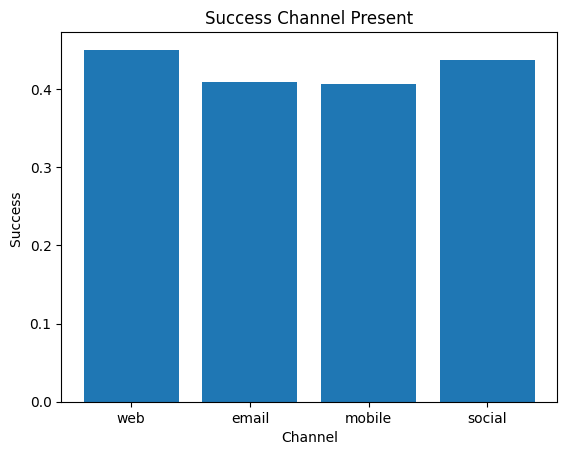

In [38]:

CHANNELU = df.groupby("n_channels")["offer_success"].mean().sort_index()
print(CHANNELU)

CHANNELU.plot(kind="bar")
plt.title("Success y # of Channels")
plt.ylabel("Success")
plt.xlabel("# Channels")
plt.tight_layout()
plt.show()
for ch in ["web","email","mobile","social"]:
    has_ch = portfolio.set_index("offer_id")["channels_list"].apply(lambda xs: 1 if ch in xs else 0)
    df[ch] = df["offer_id"].map(has_ch).fillna(0)
ch_means = {ch: df[df[ch]==1]["offer_success"].mean() for ch in ["web","email","mobile","social"]}
print(ch_means)
plt.bar(list(ch_means.keys()), list(ch_means.values()))
plt.title("Success Channel Present")
plt.ylabel("Success ")
plt.xlabel("Channel")
plt.show()


segment
2.0    0.539756
0.0    0.380524
1.0    0.363814
Name: offer_success, dtype: float64


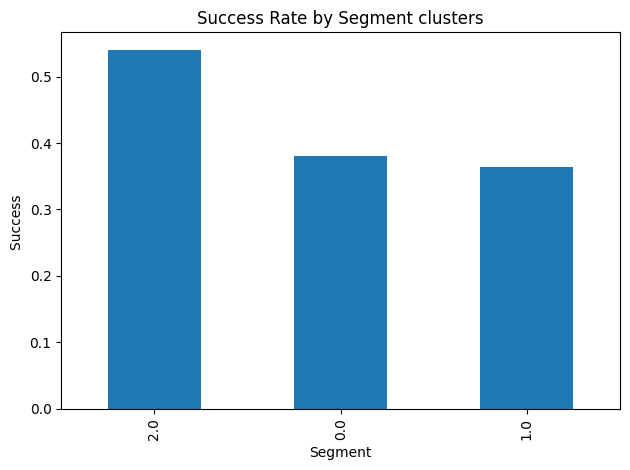

In [39]:

seg_data = df[["customer_id","age","income"]].dropna().drop_duplicates()
if len(seg_data) >= 3:
    km = KMeans(n_clusters=3, n_init=10, random_state=42)
    seg_labels = km.fit_predict(seg_data[["age","income"]])
    seg_data["segment"] = seg_labels

    seg_sr = df.merge(seg_data[["customer_id","segment"]], on="customer_id", how="left") \
               .groupby("segment")["offer_success"].mean().sort_values(ascending=False)
    print(seg_sr)

    seg_sr.plot(kind="bar")
    plt.title("Success Rate by Segment clusters")
    plt.ylabel("Success ")
    plt.xlabel("Segment")
    plt.tight_layout()
    plt.show()



In [45]:
model_df = df[["offer_success","reward","difficulty","duration","n_channels","age","income"]].dropna().copy()
if model_df["offer_success"].nunique() > 1:
    y = model_df["offer_success"].astype(int).values
    X = model_df.drop(columns=["offer_success"]).values
    lr = LogisticRegression(max_iter=500)
    lr.fit(X, y)
    pred = lr.predict(X)
    proba = lr.predict_proba(X)[:,1]

    print(classification_report(y, pred))
    print("AUC:", roc_auc_score(y, proba))



              precision    recall  f1-score   support

           0       0.69      0.76      0.72     51054
           1       0.59      0.50      0.55     35373

    accuracy                           0.66     86427
   macro avg       0.64      0.63      0.63     86427
weighted avg       0.65      0.66      0.65     86427

AUC: 0.7372245647065045
